# Случайные процессы. Прикладной поток.
## Практическое задание 5

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 5"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `5.N.ipynb` и `5.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

Варианты:

 0 . http://ita.ee.lbl.gov/html/contrib/ClarkNet-HTTP.html
 
 1 . http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html
 
 2 . http://ita.ee.lbl.gov/html/contrib/Calgary-HTTP.html
 
 3 . http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html

Нужно выбрать вариант N mod 4, где N — ваш номер из таблицы с оценками.

**Задание:**

1. Загрузите в Питоне данные, соответствующие вашему варианту. Возможно, будет удобнее воспользоваться библиотекой pandas, в частности функцией read_csv. Некоторые записи в данных могут иметь неправильный формат, поэтому сначала файл с данными придется преобразовать. В процессе преобразовании можно проигнорировать не более 1% строк, в которых указана дата (если будете удалять, напечатайте долю удаленных строк). Строки, в которых дата не указана, нужно удалить.

2. Переведите дату в timestamp-число с помощью библиотеки datetime. Например, дата 24/Oct/1994:13:41:41 преобразуется в число 782995301 с помощью кодa from datetime import datetime datetime.strptime("24/Oct/1994:13:41:41", "%d/%b/%Y:%H:%M:%S").timestamp() Подробнее читайте в документациях к библиотекам datetime и time.

3. Запросы, происходящие в некоторые моменты времени, образуют пуассоновский процесс, смысл которого — количество запросов, обработанных сервером к текущему моменту времени. Нарисуйте графики траектории этого пуассоновского процесса за все время и за первые сутки. Нарисуйте так же аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт (bytes in the reply).При построении графиков используйте код с семинара.

4. Проверьте полученный пуассоновский процесс на однородность за все время, а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час). Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара.

5. Постройте оценку функции интенсивности следующим образом. Разбейте весь временной интервал на небольшие равные по длине интервалы с достаточным количеством событий в каждом интервале (например, интерваля длинною в час). На каждом интервале оцените значение интенсивности процесса, считая его однородным на данном интервале. В какие моменты времени наблюдается наибольшая интенсивность?

6. Для получения дополнительных баллов исследуйте, есть ли зависимость интенсивности от типа хоста (host); есть ли зависимость объема запроса в байтах от времени; какой пропускной способности должны быть серверы, чтобы обрабатывать все поступающие запросы. При проведении исследования учитывайте все особенности проверки статистических гипотез. Не забывайте делать выводы.

Дополнительно:
В пятом практическом задании чтобы не ждать трое суток, пока нарисуется график траектории всего процесса, постройте точные графики траекторий пуассоновского процесса для первых 100 и 1000 событий. Для всего интервала времени постройте приближенный график с помощью plt.plot(моменты времени, range).

__________________________

### Работа начинается здесь

In [172]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.stats as sps
from datetime import datetime

____________

Скачаем данные в Питоне, что ли.

In [3]:
N = 30
print("Вариант: ", N % 4)

Вариант:  2


In [4]:
url = "ftp://ita.ee.lbl.gov/traces/calgary_access_log.gz"
fname = "calgary_access_log.gz"
unzip_fname = fname[:-3]

!wget -O $fname $url
!gunzip $fname

--2017-10-15 14:48:47--  ftp://ita.ee.lbl.gov/traces/calgary_access_log.gz
           => «calgary_access_log.gz»
Распознаётся ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164, 2620:83:8000:102::a4
Подключение к ita.ee.lbl.gov (ita.ee.lbl.gov)|131.243.2.164|:21... соединение установлено.
Выполняется вход под именем anonymous ... Выполнен вход в систему!
==> SYST ... готово.    ==> PWD ... готово.
==> TYPE I ... готово.  ==> CWD (1) /traces ... готово.
==> SIZE calgary_access_log.gz ... 5435681
==> PASV ... готово.    ==> RETR calgary_access_log.gz ... готово.
Размер (байт): 5435681 (5,2M) (не достоверно)

calgary_access_log. 100%[===================>]   5,18M   193KB/s    in 29s     

2017-10-15 14:49:19 (185 KB/s) - «calgary_access_log.gz» сохранён [5435681]

gzip: calgary_access_log already exists; do you wish to overwrite (y or n)? ^C


___________________
В файле есть строки без даты:

<code>
local - - [24/Oct/1994:15:01:37 -0600] "GET index.html HTTP/1.0" 200 780
local - - [24/Oct/1994:15:01:48 -0600] "GET 42.html HTTP/1.0" 200 3070
local - - [24/Oct/1994:15:02:30 -0600] "GET index.html HTTP/1.0" 200 3185
local - - [24/Oct/1994:15:02:31 -0600] "GET 2.gif HTTP/1.0" 200 2555
local 780     index.html
</code>

Удалим их, в условии сказано, что такие можно удалить все.
Более того, некоторые строки в данных невозможно прочесть в текстовом режиме,
ни в utf-8, ни в ascii, только в cp1251.
Поэтому будем читать бинарно. (Можно было выставить encoding в open, но постоянно обаруживались новые косяки в данных)
(как оказалось, таких три строки)
______

Позднее выяснилось, что в данных бывет вот такая прелесть
<code>
remote - - [27/Oct/1994:18:51:50 -0600] "GET index.html 200 3185
</code>
Видите вторую пару кавычек?
______
На самом деле, она в таких строках:
<code>
local - - [31/Oct/1994:13:23:41 -0700] "GET 841.html" HTTP/1.0" 404 -
</code>
___________
Такое - тоже норма.
<code>
local - - [02/Sep/1995:16:33:27 -0600] "GET 2337.gif HTTP/1.0" 200meikai - - [02/Sep/1995:16:33:27 -0600] "GET /local_interest/class_info/453/Lab3/Pics/15-small.gif HTTP/1.0" 200 5864
</code>
(это одна строка)
___________

In [98]:
regexp_date = re.compile(".*\[\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4}\].*")
regexp_all_other = re.compile(r"\w* - - \[\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4}\][^\"]*\"[^\"]*\" [\d-]* [^\"]*")
prepared_fname = "prepared_" + unzip_fname

log = False
log_strange = False
bad_code = 0             
has_no_date = 0
strange_strings = 0
total_lines = 0

with open(unzip_fname, "rb") as f_read:
    with open(prepared_fname, "w") as f_write:
        read_lines = f_read.readlines()
        v = len(read_lines)
        if log:
            print("Cтрок прочитано всего: = ", total_lines)
        for i in range(len(read_lines)):
            try:
                line = read_lines[i].decode("cp1251")
            except UnicodeDecodeError as e:
                print("Недекодируемая строка номер %d. Удалено." % (i))
                bad_code += 1
                
            if not regexp_date.match(line) is None:
                if (not regexp_all_other.match(line) is None) and  (
                    line in regexp_all_other.findall(line)):
                    f_write.write(line)
                else:
                    if log_strange: 
                        print("Что-то странное:", line)
                    strange_strings += 1
            else:
                if log: 
                    print("Нет даты. Удалено:", line)
                has_no_date += 1
            # print(i)
                      
print("bad_code = {} ({}%), has_no_date = {} ({}%), strange_strings = {} ({}%), total_lines = {} ({}%)".format(
            bad_code, round(bad_code / total_lines * 100, 3),
            has_no_date,round(has_no_date / total_lines * 100, 3),
            strange_strings,round(strange_strings / total_lines * 100, 3),
            total_lines, round(total_lines / total_lines * 100, 3)))

bad_code = 0 (0.0%), has_no_date = 1614 (0.222%), strange_strings = 328 (0.045%), total_lines = 726739 (100.0%)


In [99]:
read_lines[603041]

b'remote - - [01/Sep/1995:08:09:06 -0600] "GET 9712.gif HTTP/1.0" 200 1167\n'

In [100]:
raw_data = pd.read_csv(prepared_fname, sep=" ", header=None)

In [101]:
raw_data.head()

,0,1,2,3,4,5,6,7
0,local,-,-,[24/Oct/1994:13:41:41,-0600],GET index.html HTTP/1.0,200,150
1,local,-,-,[24/Oct/1994:13:41:41,-0600],GET 1.gif HTTP/1.0,200,1210
2,local,-,-,[24/Oct/1994:13:43:13,-0600],GET index.html HTTP/1.0,200,3185
3,local,-,-,[24/Oct/1994:13:43:14,-0600],GET 2.gif HTTP/1.0,200,2555
4,local,-,-,[24/Oct/1994:13:43:15,-0600],GET 3.gif HTTP/1.0,200,36403


Почти то, что надо. Заметим, что мы удалили меньше процента строк, даже если учитывать строки без даты.

Освежим в памяти формат данных и начнём приведение их к нормальному виду:

1. **host making** the request. Hosts are identified as either local or remote where local is a host from the University of Calgary, and remote is a host from outside of the University of Calgary domain.
2. **timestamp** in the format "DAY MON DD HH:MM:SS YYYY", where DAY is the day of the week, MON is the name of the month, DD is the day of the month, HH:MM:SS is the time of day using a 24-hour clock, and YYYY is the year. The timezone is -0700 between 30/Oct/1994:01:30:57 and 02/Apr/1995:03:03:26. For all other requests, the timezone is -0600.
3. **filename** of the requested item. Paths have been removed. Modified filenames consist of two parts: num.type , where num is a unique integer identifier, and type is the extension of the requested file.
4. **HTTP reply code**
5. **bytes in the reply** 

Не забудем про часовой пояс и про типы столбцов.
В столбце "bytes in the reply" есть отсутствующие данные. Применяя стандартный метод, заменим их на среднее значение по присутствующим данным. (хороший вопрос, какое среднее брать: медиану или среднее арифметическое (мода не очень уместна), мы выберем последнее)

In [113]:
data = pd.DataFrame()
data["host_making"] = raw_data[0].astype(str)

def time_traveler(x):
    parse = x.split(" ")
    time = parse[0][1:]
    timezone = parse[1][:-1]
    shift = 0
    if (timezone == "-0600"):
        pass
    elif (timezone == "-0700"):
        shift = - 60 * 60
    else:
        print("Wrong timezone:", time, timezone)
        
    return int(datetime.strptime(time, "%d/%b/%Y:%H:%M:%S").timestamp() + shift)

data["timestamp"] = (raw_data[3] + " " + raw_data[4]).apply(time_traveler).astype(int)
data["filename"]  = raw_data[5].astype(str)

In [121]:
data["http_reply_code"] = raw_data[6].astype(str)  # здесь есть пропуски "-"

reply_bytes_filled = np.array([int(x) for x in raw_data[7] if x != "-"])
mean_reply_bytes_filled = int(reply_bytes_filled.mean())
print("reply_bytes присутствует в {} ({}%)".format(
    len(reply_bytes_filled), round(len(reply_bytes_filled) / total_lines * 100, 3)))
print("Среднее число байт среди заполненных = ", mean_reply_bytes_filled)
reply_bytes = [int(x) if x != "-" else mean_reply_bytes_filled for x in raw_data[7]]
data["reply_bytes"] = reply_bytes

reply_bytes присутствует в 666785 (91.75%)
Средне число байт среди заполненных =  11916


In [120]:
data.head()

,host_making,timestamp,filename,http_reply_code,reply_bytes
0,local,782995301,GET index.html HTTP/1.0,200,150
1,local,782995301,GET 1.gif HTTP/1.0,200,1210
2,local,782995393,GET index.html HTTP/1.0,200,3185
3,local,782995394,GET 2.gif HTTP/1.0,200,2555
4,local,782995395,GET 3.gif HTTP/1.0,200,36403


In [111]:
print("Итого осталось строк = {}, ({}%)".format(
    data.shape[0], round(data.shape[0] / total_lines * 100, 3)))

data.info()

Итого осталось строк = 724797, (99.733%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724797 entries, 0 to 724796
Data columns (total 5 columns):
host_making        724797 non-null object
timestamp          724797 non-null int64
filename           724797 non-null object
http_reply_code    724797 non-null int64
reply_bytes        724797 non-null object
dtypes: int64(2), object(3)
memory usage: 27.6+ MB


___________________________
### Обработка данных

Нарисуем точный график для первых 100, 1000 событий, 24 часов и приближённый для всех событий.

Будем считать, что отсчёт времени начинается за секунду до прихода первого запроса.

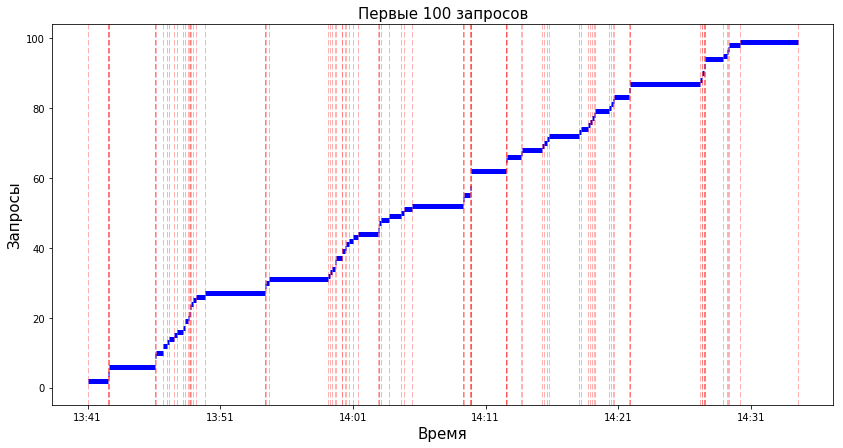

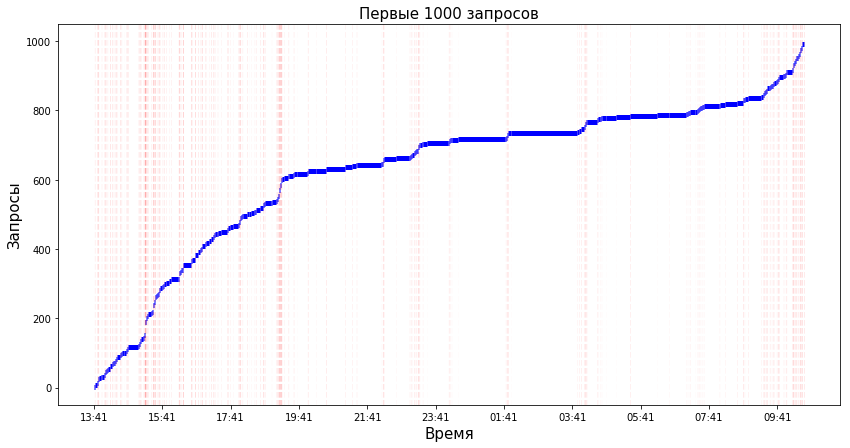

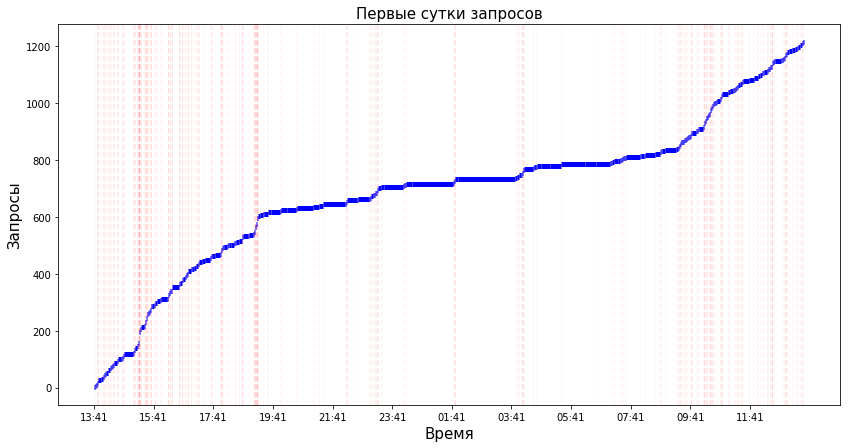

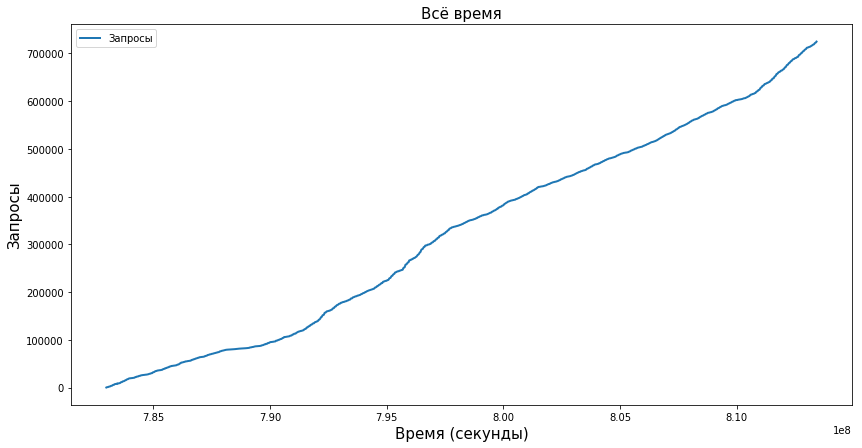

In [152]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%H:%M")

def plot_process(jumps, complex_process=None,
                 vlines=True, alpha=0.3,
                 title="", start_time=None,
                 step=2*60*60):
    
    plt.figure(figsize=(14, 7))
    last_request_time = 0
    last_level = 0
    i = 0
    while (i < len(jumps)): 
        # выделяем группу [i, i + shift - 1] запросов с одинаковым веременем
        # и рисуем линию от времени предыдущей группы до времени текущей группы
        # с уровнем, соответствующим предыдущей группе
        shift = 0
        while (i + shift < len(jumps)) and (jumps[i] == jumps[i + shift]):
            shift += 1

        if complex_process is None:  
            plt.hlines(last_level, last_request_time, jumps[i + shift - 1], lw=5, color='blue')
            last_level = i + shift
        else:
            plt.hlines(last_level, last_request_time, jumps[i + shift - 1], lw=5, color='blue')
            last_level = complex_process[:i + shift].sum()
        
        if vlines:
            plt.axvline(jumps[i], ls='--', color='red', lw=1, alpha=alpha)
        
        last_request_time = jumps[i + shift - 1]
        i += shift
    plt.title(title, fontsize=15)
    if complex_process is None:
        plt.ylabel("Запросы", fontsize=15)
    else:
        plt.ylabel("Байты", fontsize=15)
        
    plt.xlabel("Время", fontsize=15)
    if not start_time is None:
        labels = [format_time(x) for x in start_time + np.arange(0, jumps[-1], step)]
        
        plt.xticks(np.arange(0, jumps[-1], step), labels)
    plt.show()
    
    
times = (data["timestamp"].values -
        data["timestamp"].values.min() + 1)

plot_process(times[:100],
             title="Первые 100 запросов",
             start_time=data["timestamp"][0],
             step = 10 * 60)
plot_process(times[:1000],
             alpha=0.01,
             title="Первые 1000 запросов",
             start_time=data["timestamp"][0])
plot_process(times[times < 24 * 60 * 60 + 1],
             alpha=0.01,
             title="Первые сутки запросов",
             start_time=data["timestamp"][0])

plt.figure(figsize=(14, 7))
plt.plot(data["timestamp"], np.arange(len(data["timestamp"])), lw=2, label="Запросы")
plt.title("Всё время", fontsize=15)
plt.ylabel("Запросы", fontsize=15)
plt.xlabel("Время (секунды)", fontsize=15)
plt.legend()
plt.show()

**Комментарий:**
Заметим, что на графике за одни сутки интенсивность в светлое ~(09:00 - 19:00) и в тёмное время суток разная.
Нарисуем аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт.

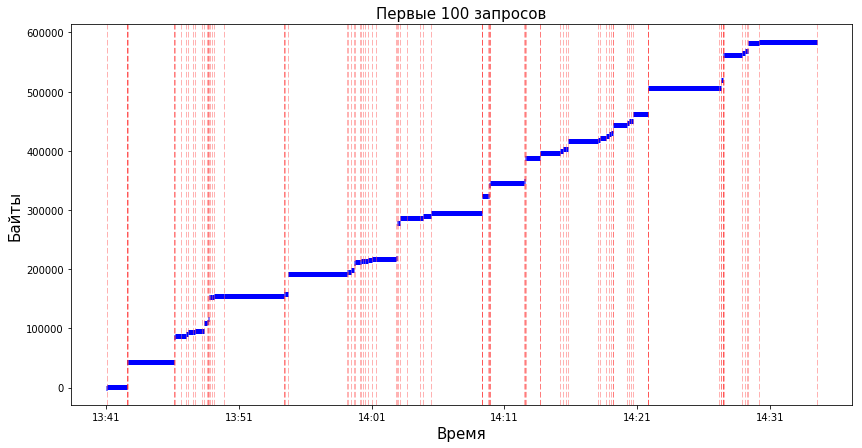

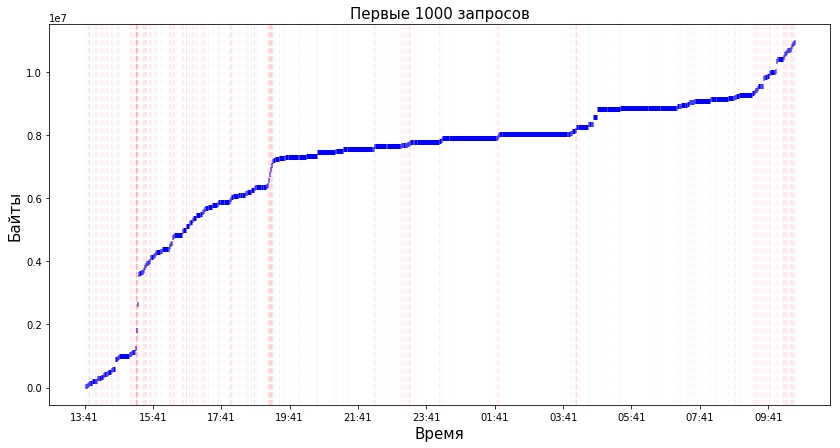

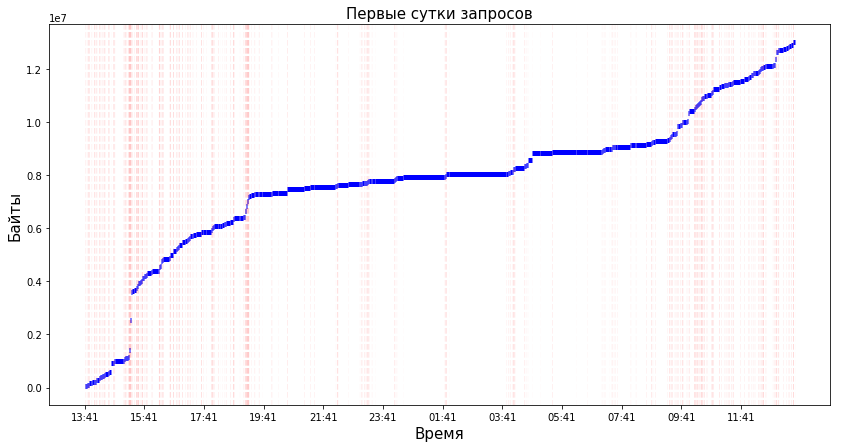

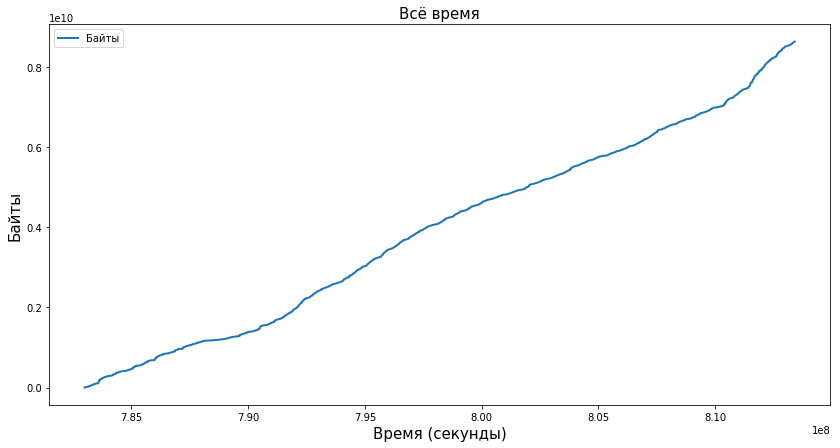

In [153]:
reply_bytes = data["reply_bytes"].values
plot_process(times[:100],
             complex_process=reply_bytes,
             title="Первые 100 запросов",
             start_time=data["timestamp"][0],
             step = 10 * 60)
plot_process(times[:1000],
             complex_process=reply_bytes,
             alpha=0.01,
             title="Первые 1000 запросов",
             start_time=data["timestamp"][0])
plot_process(times[times < 24 * 60 * 60 + 1],
             complex_process=reply_bytes,
             alpha=0.01,
             title="Первые сутки запросов",
             start_time=data["timestamp"][0])

plt.figure(figsize=(14, 7))
plt.plot(data["timestamp"], reply_bytes.cumsum(), lw=2, label="Байты")
plt.title("Всё время", fontsize=15)
plt.ylabel("Байты", fontsize=15)
plt.xlabel("Время (секунды)", fontsize=15)
plt.legend()
plt.show()

Разрывы на втором графике действительно есть:

In [155]:
format_time(data["timestamp"][data["reply_bytes"][:1000].argmax()]), data["reply_bytes"][:1000].max()

('15:15', 559259)

## Вторая половина задания

### Проверка на однородность

Напишем, с использование материалов первого семинара, функцию проверки на однородность

In [302]:
def chisquare_format(result, alpha=0.05, log=True):
    if log:
        print("Статистика критерия хи-квадрат:", round(result.statistic, 3))
        print("p-value: ", round(result.pvalue, 3))
    if result.pvalue < alpha:
        if log:
            print("Гипотеза отвергается.")
        return True  # да, отверглась
    else:
        if log:
            print("Гипотеза не отвергается.")
        return False  # нет, не отверглась
        
def poission_process_uniformity_check(jumps, division, log=True, hist_log=False):
    """T_start = jumps.min()
    T_end = jumps.max()
    events2 = np.zeros(division)
    for i in range(division):
        for time in jumps:
            if ((T_end - T_start) / division * i <= time -T_start <= ((T_end - T_start) / division * (i+1))):
                events2[i]+=1"""
    events = np.histogram(jumps, bins=division)
    expected = np.ones(division) * len(jumps) / division
    if hist_log:
        print(events[0])
        print(expected)
    #print(events2)
    # assert (events[0] == events2).all()
    return chisquare_format(sps.chisquare(events[0], expected), log=log)

Для тестирования, как и предлагается, используем код с семинара, изучив его. Предлагается брать код, основанный на условном распределении моментов скачков при условии $N_t = n$

In [282]:
def get_poisson_process(T = 20, l = 1):
     # l - интенсивность
    N_T = sps.poisson(mu=l*T).rvs()
    jumps = sps.uniform(loc=0, scale=T).rvs(size=N_T)  # моменты скачков (не упоряд.)
    jumps.sort()
    return jumps

In [287]:
rejected = 0
not_rejected = 0

for T in [70, 100, 150, 1000, 100000, 1000000]:
    for k in [3, 5, 7, 10, 15]:
        for l in [0.5, 1, 3, 5, 7]:
            jumps = get_poisson_process(T=T, l=l)
            if (len(jumps) >= 50):  # требование теста
                if poission_process_uniformity_check(jumps, k, log=False):
                    rejected += 1
                else:
                    not_rejected += 1

print("Отвергнута {} раз ({}%)".format(rejected,
                                       round(rejected / (rejected + not_rejected) *100, 2)))

Отвергнута 4 раз (0.03%)


**Комментарий:**
Полученное значение меньше (сравнимо c) 0.05 и его можно считать приемлемым.

Подкинем теперь ей неоднородный процесс с семинара.

In [290]:
def get_not_uniform_poisson_process(T = 72, l = 5 * 2.5):
    # T = 72 - трое суток
    # l = 5 * 2.5 максимальное значение интенсивности

    S = 0
    xi = [0]
    while S < T:
        value = sps.expon(scale=1/l).rvs()
        if sps.uniform.rvs() < 5 * (np.sin(S * np.pi/12 + 10) + 1.5) / l:
            xi.append(value)
        else:
            xi[-1] += value
        S += value
    jumps = np.cumsum(xi)
    jumps[0] = 0
    return jumps

In [298]:
rejected = 0
not_rejected = 0

for T in [70, 100, 150, 500, 1000]: # 1000000]:
        for l in [8, 9, 10, 11, 12]:
            jumps = get_not_uniform_poisson_process(T=T, l=l)
            if (len(jumps) >= 50):  # требование теста
                if poission_process_uniformity_check(jumps, k, log=False):
                    rejected += 1
                else:
                    not_rejected += 1

print("Отвергнута {} раз ({}%)".format(rejected,
                                       round(rejected / (rejected + not_rejected) *100, 2)))

Отвергнута 21 раз (84.0%)


Не очень высокий, но, субьективно-премлемый результат.

_____________
Проверим теперь однородность данных

In [321]:
times = data["timestamp"].values
gettime = lambda lo, hi: (lo <= times) & (times < hi)
hour = 60*60
day = 24 * hour
week = day * 7
for shift, name in [(hour, "час"), (day, "день"), (week, "неделя")]:
    print("Проверка за первый/ую:", name)
    poission_process_uniformity_check(times[gettime(times[0], times[0] + shift)], 5)
    print("\n")
    
print("Всё время:")
poission_process_uniformity_check(times, 5)

Проверка за первый/ую: час
Статистика критерия хи-квадрат: 0.906
p-value:  0.924
Гипотеза не отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 653.585
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: неделя
Статистика критерия хи-квадрат: 1098.786
p-value:  0.0
Гипотеза отвергается.


Всё время:
Статистика критерия хи-квадрат: 51297.279
p-value:  0.0
Гипотеза отвергается.


True

**Комментарий:**
Вообще говоря, полученные данные согласуются с очевидной зависимостью день-ночь интенсивности, наблюдавшейся на графиках выше.

Проверим ещё раз данные для некоторых сдвигов, для промежутков час и день. 

In [335]:
for start_shift in [day+ hour, 4*day + 4*hour, 9*day,
                    15*day + 15*hour, 30*day+ 30*hour, 100*day]:
    for shift, name in [(hour, "час"), (day, "день")]:
        print("Проверка за первый/ую:", name)
        poission_process_uniformity_check(
            times[gettime(start_shift+ times[0], start_shift + times[0] + shift)], 5)
        print("\n")

Проверка за первый/ую: час
Статистика критерия хи-квадрат: 47.875
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 399.945
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: час
Статистика критерия хи-квадрат: 2.095
p-value:  0.718
Гипотеза не отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 182.935
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: час
Статистика критерия хи-квадрат: 3.232
p-value:  0.52
Гипотеза не отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 715.061
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: час
Статистика критерия хи-квадрат: 19.429
p-value:  0.001
Гипотеза отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 984.265
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: час
Статистика критерия хи-квадрат: 3.071
p-value:  0.546
Гипотеза не отвергается.


Проверка за первый/ую: день
Статистика крит

Видим, что однородность процесса для "дня" всегда отвергается, а для часа - когда как. Возможно, при некоторых условиях, в некоторое время процессы однородны. (гипотезы для некоторых дней не отвергнуты, возможно есть сложные зависимости, при выполнении некоторых условии, дающих однородность процесса, но, возможно, мы просто не смогли отвергнуть неверную гипотезу)

______
#### Оценка функции интенсивности

Для распределения пуассона ОМП $\lambda = \overline{X}$
Так как $(N_{t+T} - N_{t}) \sim Pois(\lambda(T))$, то разделяя всё время на промежутки по T, оценку интенсивности можно произвести так:
$\forall t \in [t_0, t_0 + T]: \lambda(t) = \overline{X} / T$, где $X = \{X_{-k}, X_{-k+1}, ... X_{+k}\}, X_i = N_{t+Ti} - N_{t + T (i-1)}$

In [343]:
T = 60  # минута
times = data["timestamp"].values

deltas = np.zeros(int((times[-1] - times[0]) / T + 0.5))  # округление вверх
for t in times:
    deltas[(t - times[0])//T] += 1

In [344]:
deltas

array([ 2.,  4.,  0., ...,  2.,  0.,  1.])

In [377]:
lambdas = [deltas[t - T//2: t + T//2].mean() / T if t >= T//2 else 0 for t in range(0, len(deltas) - T//2)]
# на каждую минуту, усредняя по часу, начиная с 30-й минуты. Первые 30 значений заполним нулями,
# чтобы упростить визуализацию

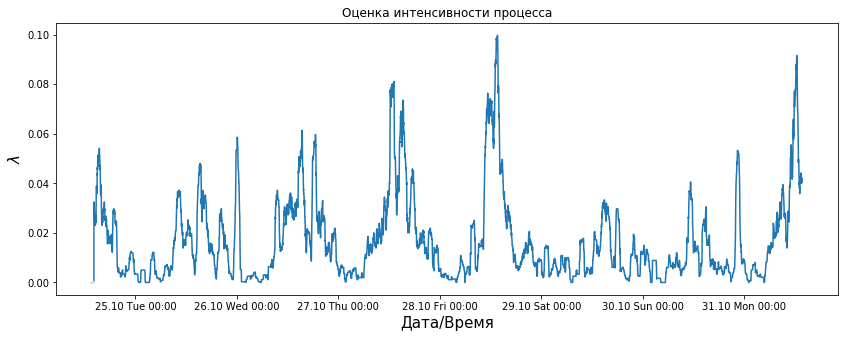

In [382]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%d.%m %a %H:%M")

how_mamy = 7* 24 * 60  # неделя
step = 24 * 60  # сутки
start_time = times[0]
plt.figure(figsize=(14, 5))
plt.plot(np.arange(how_mamy), lambdas[:how_mamy])
plt.plot(np.arange(30), lambdas[:30], color="white")  # а вот и нет нулей.))
plt.xlabel("Дата/Время", fontsize=15)
plt.ylabel(r"$\lambda$", fontsize=15)
plt.title("Оценка интенсивности процесса")
labels = [format_time(x) for x in start_time + np.arange(24*60 - (13*60 + 41), np.arange(how_mamy)[-1], step)*60] 
plt.xticks(np.arange(24*60 - (13*60 + 41), np.arange(how_mamy)[-1], step), labels)
plt.show()

**Комментарий:** Очевидна зависимость интенсивности как от времени суток, так и от дня недели: в выходные интенсивность растёт днём меньше, чем в рабочие дни.

['13:41', '16:41', '19:41', '22:41', '01:41', '04:41', '07:41', '10:41', '13:41', '16:41', '19:41', '22:41', '01:41', '04:41', '07:41', '10:41', '13:41', '16:41', '19:41', '22:41', '01:41', '04:41', '07:41', '10:41']


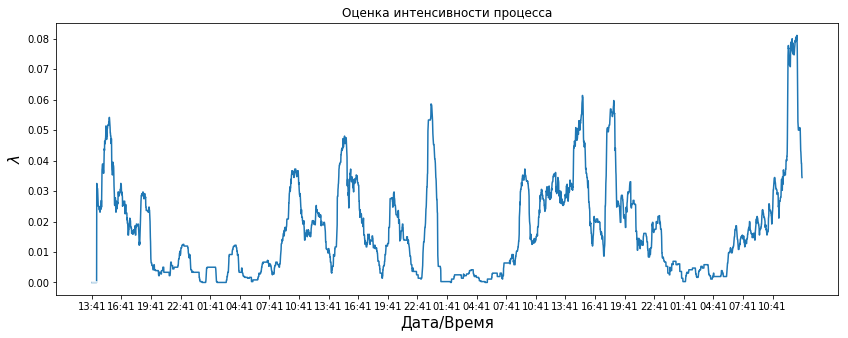

In [397]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%H:%M")

how_mamy = 3 * 24 * 60  # день
step = 3 * 60  # час
start_time = times[0]
plt.figure(figsize=(14, 5))
plt.plot(np.arange(how_mamy), lambdas[:how_mamy])
plt.plot(np.arange(30), lambdas[:30], color="white")  # а вот и нет нулей.))
plt.xlabel("Дата/Время", fontsize=15)
plt.ylabel(r"$\lambda$", fontsize=15)
plt.title("Оценка интенсивности процесса")
labels = [format_time(x) for x in start_time + np.arange(0, how_mamy, step)*60] 
print(labels)
plt.xticks(np.arange(0, how_mamy, step), labels)
plt.show()

**Комментарий:** Видно, что максимумы интенсивностей приходятся на середину рабочего дня - около 14 - 15 часов дня.

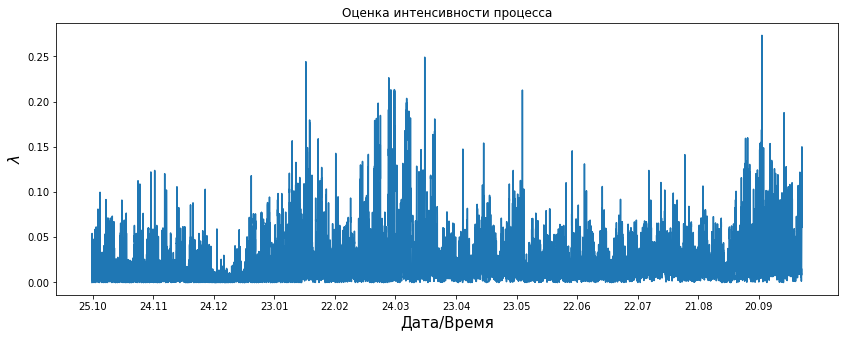

In [403]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%d.%m")

how_mamy = len(lambdas)  # неделя
step = 30 * 24 * 60  # сутки
start_time = times[0]
plt.figure(figsize=(14, 5))
plt.plot(np.arange(how_mamy), lambdas[:how_mamy])
plt.plot(np.arange(30), lambdas[:30], color="white")  # а вот и нет нулей.))
plt.xlabel("Дата/Время", fontsize=15)
plt.ylabel(r"$\lambda$", fontsize=15)
plt.title("Оценка интенсивности процесса")
labels = [format_time(x) for x in start_time + np.arange(24*60 - (13*60 + 41), np.arange(how_mamy)[-1], step)*60] 
plt.xticks(np.arange(24*60 - (13*60 + 41), np.arange(how_mamy)[-1], step), labels)
plt.show()

**Комментарий:**
На полном графике по всем данным видно, что в предновогоднюю и посленовогоднюю неделю интенсивность падает, что очевидно.
Видны также черты (в среднем четыре на месяц) - выходные дни.

Понятно, что выводы в целом очевидны, ведь запросы - HTTP requests to the University of Calgary's Department of Computer Science WWW server located at Calgary, Alberta, Canada - и понятно, что в выходные и ночью запросов должно быть много меньше. (Вот только на личном примере эти утверждения опровергаются.)